# Brain Tumor Segmentation using U-Net (Keras)

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint


In [16]:
# Set base path to your split dataset
base_path = r"D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\U-Net\processed\split"

IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 15


In [17]:
def load_data(split):
    image_paths = sorted(glob(os.path.join(base_path, split, "images", "*.png")))
    mask_paths = sorted(glob(os.path.join(base_path, split, "masks", "*.png")))
    
    images, masks = [], []
    for img_path, msk_path in zip(image_paths, mask_paths):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        msk = cv2.resize(msk, (IMG_SIZE, IMG_SIZE)) / 255.0

        images.append(img[..., np.newaxis])
        masks.append(msk[..., np.newaxis])

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)


In [18]:
# Load data
X_train, y_train = load_data("train")
X_val, y_val = load_data("val")
X_test, y_test = load_data("test")

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (2144, 256, 256, 1), Val: (612, 256, 256, 1), Test: (308, 256, 256, 1)


In [19]:
# U-Net Architecture
def unet(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    c1 = layers.Dropout(0.3)(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    c2 = layers.Dropout(0.3)(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.3)(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [20]:
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5, restore_best_weights=True)

model = unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Save best model
checkpoint = ModelCheckpoint("best_unet_model.keras", save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpoint, earlystop])


Epoch 1/15


c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_35']
Received: inputs=Tensor(shape=(8, 256, 256, 1))
  warnings.warn(msg)


268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9499 - loss: 0.3331

c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_35']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


268/268 ━━━━━━━━━━━━━━━━━━━━ 194s 708ms/step - accuracy: 0.9500 - loss: 0.3325 - val_accuracy: 0.9827 - val_loss: 0.0741
Epoch 2/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 181s 676ms/step - accuracy: 0.9826 - loss: 0.0680 - val_accuracy: 0.9827 - val_loss: 0.0705
Epoch 3/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 182s 678ms/step - accuracy: 0.9828 - loss: 0.0653 - val_accuracy: 0.9827 - val_loss: 0.0705
Epoch 4/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 181s 674ms/step - accuracy: 0.9828 - loss: 0.0642 - val_accuracy: 0.9827 - val_loss: 0.0662
Epoch 5/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 189s 705ms/step - accuracy: 0.9828 - loss: 0.0625 - val_accuracy: 0.9827 - val_loss: 0.0650
Epoch 6/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 194s 723ms/step - accuracy: 0.9824 - loss: 0.0591 - val_accuracy: 0.9827 - val_loss: 0.0599
Epoch 7/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 185s 692ms/step - accuracy: 0.9828 - loss: 0.0528 - val_accuracy: 0.9827 - val_loss: 0.0547
Epoch 8/15
268/268 ━━━━━━━━━━━━━━━━━━━━ 180s 671ms/step - accuracy: 0.9833 - loss: 0.04

In [21]:
# Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 757ms/step - accuracy: 0.9893 - loss: 0.0325

Test Loss: 0.0353 | Test Accuracy: 0.9882


c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_35']
Received: inputs=Tensor(shape=(5, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


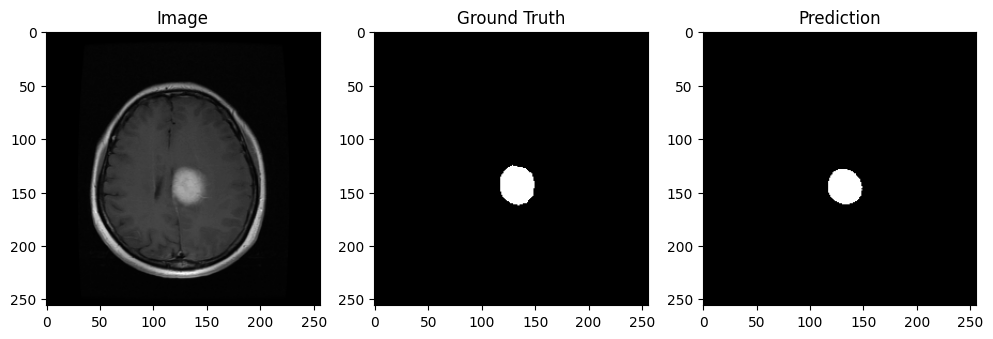

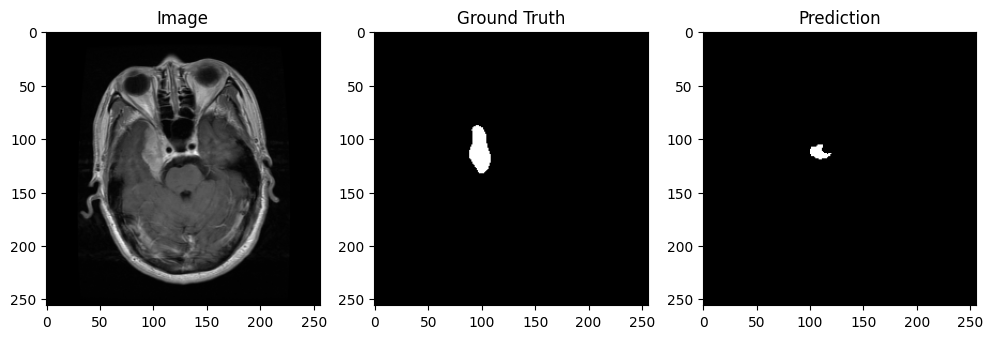

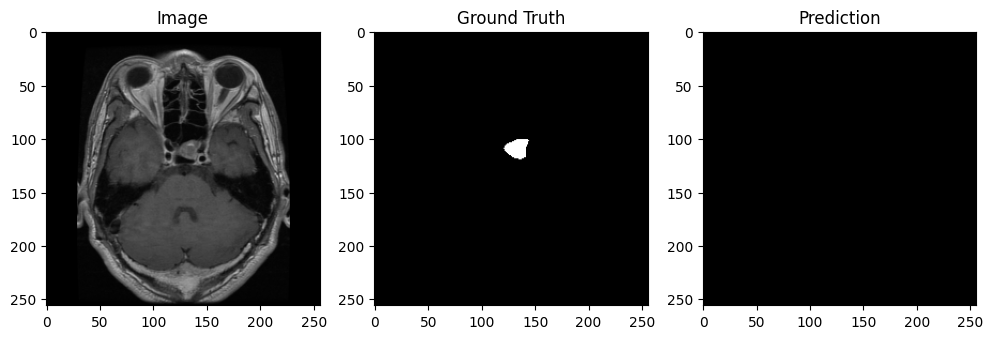

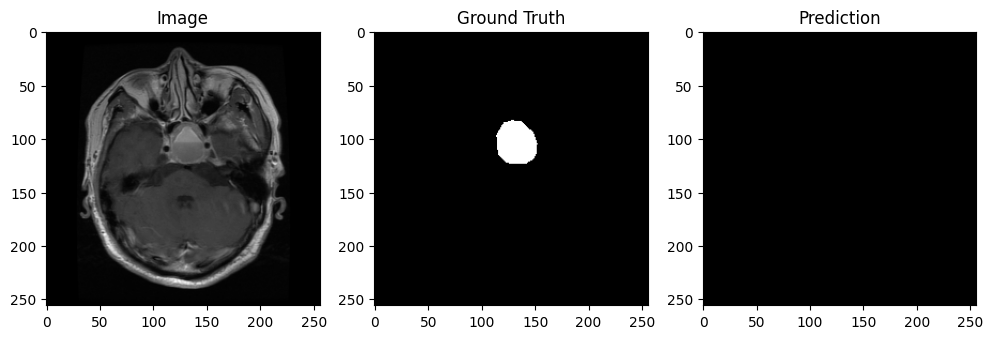

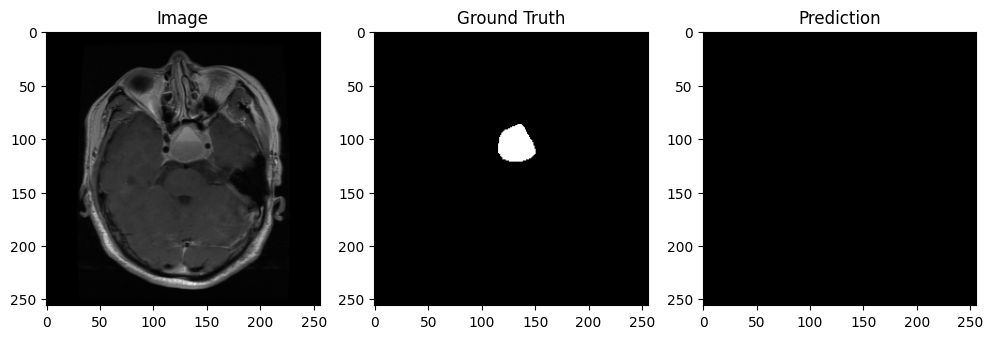

In [22]:
# Visualize Predictions
preds = model.predict(X_test[:5])
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow((preds[i].squeeze() > 0.5).astype(np.uint8), cmap='gray')
    plt.show()
